# **Preprocessing**

### **Eksplorasi Data**

Pada tahapan ini saya akan melakukan beberapa persiapan dan juga mencoba memeahami isi dari data tersebut mulai dari banyaknya data pada setiap label dan lain lain.

In [1]:
# menyiapkan library
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
import re
import string

lalu disini saya melakukan importing pada dataset untuk mengetahui isi dari data tersebut

In [2]:
# melakukan pengambilan data
df = pd.read_csv("TABEL DATA LATIH HATESPEECH RISET.xlsx - Sheet1.csv")

# melihat data
df.head()

,username,comment,label
0,dxndelin,@amyliarm lingkunganmu keknya punya pemahaman ...,Netral
1,__succiduous,Udah jelek brengsek pula,Ras
2,KemenagMempawah,Lucunya penghuni negeri ini selalu di hiasi da...,Agama
3,1stKOREANguy1,"Yang jelek + miskin udah pasti bukan Kristen ,...",Ras
4,newsutdofficial,@MurtadhaOne1 Mereka memanfaatkan kebodohan ka...,Agama


Lalu kita akan coba telusuri banyaknya data untuk setiap labelnya. Jikalau tidak seimbang maka nantinya akan saya proses lagi. Karena kalau label tidak seimbang, maka akan berpotensi overfitting. Mengapa overfitting ? dikarenakan model akan lebih cenderung belajar pada data yang paling banyak, sehingga dia akan sulit mengenali pada data dengan class yang jumlahnya sedikit. 

In [3]:
# banyaknya data pada setiap class
df.label.value_counts()

label
Netral    836
Ras       601
Agama     563
Name: count, dtype: int64

Setelah saya lakukan analisa ternyata keseimbangan datanya sudah cukup bagus

### **Seleksi Fitur**

Pada tahapan ini kita akan mencoba menyeleksi fitur pada data kita. Kita akan menghapus untuk fitur yang tidak diperlukan. Setelah melihat datanya saya bisa menentukan bahwa fitur yang kita perlukan hanya comment dan label saja. Comment yang akan menjadi data x nya nanti dan label sebagai data y nya nanti

In [4]:
# menghilangkan fitur
df.drop(columns="username", inplace=True)

# mlihat data
df.head()

,comment,label
0,@amyliarm lingkunganmu keknya punya pemahaman ...,Netral
1,Udah jelek brengsek pula,Ras
2,Lucunya penghuni negeri ini selalu di hiasi da...,Agama
3,"Yang jelek + miskin udah pasti bukan Kristen ,...",Ras
4,@MurtadhaOne1 Mereka memanfaatkan kebodohan ka...,Agama


### **Cleaning**

**Nilai yang Hilang**

kita akan mencari apakah ada data yang hilang. Untuk memastikan bahwa data ini tidak ada yang hilang. **Mengapa harus di cek lagi ?** karena jika benar benar ada data yang hilang, maka akan berpotensi **kesalahpahaman oleh model**. Misal pada text terisi Nan (karena tidak ada nilainya) maka model akan mengira kalau text tersebut memiliki text yang berisi "Nan"

In [5]:
# jumlah nilai hilang jenis Nan
df.isna().sum()

comment    3
label      4
dtype: int64

kita dapat melihta kalau ada data kosong di kolom comment sebanyak 3 data dan data kosong di label ada 4 data. Yang kita lakukan adalah **mengdrop / menghilangkan data yang kosong** ini. Kenapa kok dihilangkan bukan di cari rata rata atau lainnya. Karena data text pada comment itu unik untuk setiap datanya. Maka tidak bisa dilakukan pencarian mean, modus, atau lain lain.

In [6]:
# melihat data unik pada label
df.label.unique()

array(['Netral', 'Ras', 'Agama', nan], dtype=object)

In [7]:
# menghilangkan data kosong
df.dropna(inplace=True)

# melihat banyak data kosong
df.isna().sum()

comment    0
label      0
dtype: int64

**Data yang Terduplikasi**

kita akan mencari apakah ada data yang terduplikasi atau tidak. **mengapa kita perlu mencari apakah ada data yang duplikasi** ? karena jika data yang terduplikasi ini dibiarkan maka akan **menimbulkan overfitting** karena model akan **cenderung menghafal** pada data yang terduplikasi. Jikalau model ini menghafal maka yang terjadi dia akan **kesulitan untuk menebak data yang baru**

In [8]:
# melihat data yang terduplikasi
df[df.comment.duplicated()]

,comment,label
143,"@VIVAcoid Sudahlah,Dia mnjabat sbg menteri saj...",Netral
144,@banjarbase Agama jgn dijadikan tolak ukur lag...,Netral
269,@yonkpaws Jelek klodia ðŸ˜”ðŸ˜”,Ras
387,gua kok ngerekam suara gue jelek amat anjir bi...,Agama
398,Ini contoh Islam yg ga bener + contoh kristen ...,Agama
...,...,...
1728,IKN Potret Kemajuan,Netral
1730,IKN Potret Kemajuan,Netral
1733,IKN Potret Kemajuan,Netral
1811,IKN Potret Kemajuan,Netral


di atas kita dapat melihat kalau **ada data yang terduplikasi**. Maka selanjutnya kita perlu menghilangkan salah satu data yang terduplikasi ini. Kita dapat menggunakan function yang ada di pandas

In [9]:
# menghilangkan data yang terduplikasi
df.drop_duplicates(inplace=True)

# melihat banyaknya data yang terduplikasi
df[df.comment.duplicated()]

,comment,label
387,gua kok ngerekam suara gue jelek amat anjir bi...,Agama
458,@RazmanZakaria60 apa sumbangan PAS kepada nega...,Agama
477,@Motty_hang yang benci FPI PKI dan kaum munafikun,Agama
491,@souIsinlove kpop k nya kafir jahat setan wall...,Agama
512,"gausah senyum kau didepan ku kntl, jelek kau b...",Ras
600,"@kompascom Maka, oleh sebab itu bertindaklah s...",Ras
1671,@apoycuy Tokoh agama di Papua kecam penyeranga...,Ras


### **Train Test Split**

Pada tahapan ini kita akan melakukan splitting data menjadi data yang digunakan khusus untuk train dan data yang digunakan khusus untuk test. Mengapa hal ini perlu dilakukan, karena agar kita dapat melihat performa model kita melalui data yang baru (data test)

In [10]:
# akan mengembalikan data yang sudah di split
def Train_Test_Split(x, y, random_seed=None, test_size=0.2):
    n = len(x) # banyak data

    # jika punya seed
    if random_seed:
        np.random.seed(random_seed)
    
    # banyak data test
    test_size = int(test_size * n)

    # menentukan index secara random
    indices = np.random.permutation(n)
    train_indices, test_indices = indices[test_size:], indices[:test_size]

    return x.iloc[train_indices], x.iloc[test_indices], y.iloc[train_indices], y.iloc[test_indices]
# menentukan x dan y nya
x = df["comment"]
y = df["label"]

# splitting pada data kita
X_train, X_test, y_train, y_test  = Train_Test_Split(x, y, random_seed=42)

y_train = y_train.map({"Netral": 0, "Agama":1, "Ras":2})


# melihat isi data train
X_train

1796    Indonesia Negara Hukum\r\n Assalamuâ€™alaikum\...
908     Ã¢â‚¬Å“Tergantung interpretasi masing-masing i...
575     Terbukti benar hrus dipercaya benar, tak jelas...
1697    menurutku penyakit kita bukan pada pakaian dan...
1475    @WagimanDeep212_ Berbalut agama makan duit don...
                              ...                        
1179    @maman1965 Berusaha menghormati adat istiadat ...
1343    @ZacZakirin13 @syazreenaaa Tapi menteri agama ...
906     @OposisiCerdas Murtad aja keles susah bgt. Toh...
1510    WARTAWAN RASMI LAMAN REFORMASI: TIK TOK KHALID...
1175    PENGURUS BARU HMI dari BANDUNG pakai KALUNG SA...
Name: comment, Length: 1557, dtype: object

### **Case Folding**

Pada tahapan ini kita akan menghilangkan karakter karakter yang **tidak memiliki makna dalam segi bahasa** yang ada pada data comment. Karakter seperti tag, hashtag, link, emoji, dan lain lain. Karena karakter jenis ini terlalu unik maka kita perlu menghilkangkannya. Karakter yang **terlalu unik umumnya tidak memiliki pola**.

In [11]:
# akan mengembalikan text yang sudah di case
def case_folding(text):
    # menghilangkan tag
    text = re.sub(r"@[A-Za-z0-9_]+", "", text)
    # menghilangkan hashtag
    text = re.sub(r"#\w+", "", text)
    # menghilangkan link
    text = re.sub(r"https?://\S+", "", text)
    # menghilangkan newline atau enter
    text = re.sub(r"\n+", "", text)
    # menghilangkan \r
    text = re.sub(r"\r+", "", text)
    # menghilangkan nomer
    text = re.sub(r"\d+", "", text)

    # menghilangkan simbol
    text = text.translate(str.maketrans("", "", string.punctuation))

    # menghilangkan emoji
    emoji_pattern = re.compile("["
                               u"\U0001F600-\U0001F64F"
                               u"\U0001F300-\U0001F5FF"
                               u"\U0001F680-\U0001F6FF"
                               u"\U00010000-\U0010ffff"
                               "]+", flags=re.UNICODE)
    text = emoji_pattern.sub(r"", text).lower()

    # menghilangkan karakter diluar latin
    qwerty = "abcdefghijklmnopqrstuvwxyz "
    text = "".join([letter for letter in text if letter in qwerty])

    # memperkecil huruf
    return text

# mengimplementasikann untuk setiap doc
X_train = X_train.apply(case_folding)
X_train

1796    indonesia negara hukum assalamualaikum  untuk ...
908     tergantung interpretasi masingmasing individu ...
575     terbukti benar hrus dipercaya benar tak jelas ...
1697    menurutku penyakit kita bukan pada pakaian dan...
1475      berbalut agama makan duit donasi  luarbiasa bgt
                              ...                        
1179     berusaha menghormati adat istiadat lokal seti...
1343                          tapi menteri agama dari pas
906      murtad aja keles susah bgt toh allah dan agam...
1510    wartawan rasmi laman reformasi tik tok khalid ...
1175    pengurus baru hmi dari bandung pakai kalung sa...
Name: comment, Length: 1557, dtype: object

### **Tokenize**

Pada tahapan ini kita akan melakukan **pemisahan** untuk setiap document nya menjadi **list kata**. Tujuannya adalah kata ini akan menjadi fitur nantinya dalam pembobotan kata

In [12]:
# akan mengembalikan documen yang sudah di tokenize
def tokenize(text):
    return word_tokenize(text)

# mengimplementasikan untuk setiap doc
X_train = X_train.apply(tokenize)
X_train

1796    [indonesia, negara, hukum, assalamualaikum, un...
908     [tergantung, interpretasi, masingmasing, indiv...
575     [terbukti, benar, hrus, dipercaya, benar, tak,...
1697    [menurutku, penyakit, kita, bukan, pada, pakai...
1475    [berbalut, agama, makan, duit, donasi, luarbia...
                              ...                        
1179    [berusaha, menghormati, adat, istiadat, lokal,...
1343                    [tapi, menteri, agama, dari, pas]
906     [murtad, aja, keles, susah, bgt, toh, allah, d...
1510    [wartawan, rasmi, laman, reformasi, tik, tok, ...
1175    [pengurus, baru, hmi, dari, bandung, pakai, ka...
Name: comment, Length: 1557, dtype: object

### **Normalize**

Pada proses ini kita akan mengubah kata yang **tidak baku menjadi kata baku / kata yang umum menjadi kata yang umum**. Seperti singkatan singkatan menjadi kata yang aslinya. Tujuannya adalah agar menjadikan sama makna yang disingkat dengan yang tidak disingkat

In [13]:
# kata yang harus dinormalize
norm_word = {
    "emg" : "memang",
    "saiz" : "size",
    "cino" : "cina",
    "jowo" : "jawa",
    "kite" : "kita",
    "lg" : "lagi",
    "aj" : "aja",
    "yg" : "yang",
    "pdhl" : "padahal",
    "napa" : "kenapa",
    "dh" : "sudah",
    "udh" : "sudah",
    "tdk" : "tidak",
    "sm" : "sama",
    "ga" : "tidak",
    "bgt" : "banget",
    "mentri" : "menteri",
    "embantu" : "membantu",
    "dlm" : "dalam",
    "bdang" : "bidang",
    "msh" : "masih",
    "ampe" : "sampai",
    "ky" : "kaya",
    "nnya" : "tanya",
    "krn" : "karena",
    "jir" : "anjing",
    "ajg" : "anjing",
    "anjir" : "anjing",
    "gak" : "tidak",
    "ak" : "aku",
    "dasr" : "dasar",
    "lgsg" : "langsung",
    "skrg" : "sekarang",
    "gw" : "gua",
    "w" : "gua",
    "engga" : "tidak",
    "dgn" : "dengan",
    "orng" : "orang",
    "org" : "orang",
    "ni" : "ini",
    "jgn" : "jangan",
    "mbahas" : "bahas",
    "krna" : "karena",
    "ma" : "sama",
    "sblm" : "sebelum",
    "tp" : "tapi",
    "sbg" : "sebagai"
}

# melakukan normalisasi
def normalize(text):
    return [norm_word[word] if word in norm_word else word for word in text]

# mengimplementasikan untuk setiap doc
X_train = X_train.apply(normalize)
X_train

1796    [indonesia, negara, hukum, assalamualaikum, un...
908     [tergantung, interpretasi, masingmasing, indiv...
575     [terbukti, benar, hrus, dipercaya, benar, tak,...
1697    [menurutku, penyakit, kita, bukan, pada, pakai...
1475    [berbalut, agama, makan, duit, donasi, luarbia...
                              ...                        
1179    [berusaha, menghormati, adat, istiadat, lokal,...
1343                    [tapi, menteri, agama, dari, pas]
906     [murtad, aja, keles, susah, banget, toh, allah...
1510    [wartawan, rasmi, laman, reformasi, tik, tok, ...
1175    [pengurus, baru, hmi, dari, bandung, pakai, ka...
Name: comment, Length: 1557, dtype: object

### **Menghilangkan Stopwords**

Pada tahapan ini kita akan menyeleksi kata tertentu. Kita akan **menghilangkan kata yang tidak memiliki makna secara independen**. **Mengapa harus dihilangkan ?** dikarenakan nantinya yang akan **dilakukan pembobotan** kata akan memerlukan makna yang independen pada setiap fitur nya. Jika maknanya itu dependen dan terikat pada kata yang lainnya maka akan berbeda beda maknanya. Jika makna beda, maka tidak ada pola nanti datanya. Contoh konjungsi, kata penjelas, dan lain lain.

In [14]:
# kata yang harus di stop
stopw = stopwords.words("indonesian")

# mengembalikan kata yang sudah di stop
def stopword(text):
    return [word for word in text if word not in stopw and len(word) >=2 ]

# mengimplementasikan untuk setiap doc
X_train = X_train.apply(stopword)
X_train

1796    [indonesia, negara, hukum, assalamualaikum, me...
908     [tergantung, interpretasi, masingmasing, indiv...
575     [terbukti, hrus, dipercaya, salah, dipercaya, ...
1697    [menurutku, penyakit, pakaian, asesories, akar...
1475    [berbalut, agama, makan, duit, donasi, luarbia...
                              ...                        
1179    [berusaha, menghormati, adat, istiadat, lokal,...
1343                                [menteri, agama, pas]
906     [murtad, aja, keles, susah, banget, allah, aga...
1510    [wartawan, rasmi, laman, reformasi, tik, tok, ...
1175    [pengurus, hmi, bandung, pakai, kalung, salib,...
Name: comment, Length: 1557, dtype: object

### **Stemming**

Pada tahapan ini kita akan melakukan pengubahan kata kata menjadi kata dasarnya. Tujuannya adalah agar memperkecil variasinya sehingga model juga akan memahami bahwa kata yang belum dasar memiliki makna yang sama dengan kata dasarnya. Misal Penyanyi menjadi nyanyi, Pemahaman menjadi paham.

In [15]:
stemmer = StemmerFactory().create_stemmer()

def stemming(text):
    return [stemmer.stem(word) for word in text]

# mengimplementasikan untuk setiap doc
X_train = X_train.apply(stemming)
X_train

1796    [indonesia, negara, hukum, assalamualaikum, le...
908     [gantung, interpretasi, masingmasing, individu...
575     [bukti, hrus, percaya, salah, percaya, salah, ...
1697    [turut, sakit, pakai, asesories, akar, budaya,...
1475    [balut, agama, makan, duit, donasi, luarbiasa,...
                              ...                        
1179    [usaha, hormat, adat, istiadat, lokal, kali, s...
1343                                [menteri, agama, pas]
906     [murtad, aja, les, susah, banget, allah, agama...
1510    [wartawan, rasmi, laman, reformasi, tik, tok, ...
1175    [urus, hmi, bandung, pakai, kalung, salib, lan...
Name: comment, Length: 1557, dtype: object

**Kemunculan Data** 

Pada tahapan kita akan mencari kata yang paling sering disebut di setiap class

In [16]:
# data yang ingin dilabeli
labeled_data = X_train.to_frame()

# melabeli data
labeled_data["label"] = y_train

labeled_data

,comment,label
1796,"[indonesia, negara, hukum, assalamualaikum, le...",0
908,"[gantung, interpretasi, masingmasing, individu...",0
575,"[bukti, hrus, percaya, salah, percaya, salah, ...",1
1697,"[turut, sakit, pakai, asesories, akar, budaya,...",0
1475,"[balut, agama, makan, duit, donasi, luarbiasa,...",1
...,...,...
1179,"[usaha, hormat, adat, istiadat, lokal, kali, s...",0
1343,"[menteri, agama, pas]",0
906,"[murtad, aja, les, susah, banget, allah, agama...",1
1510,"[wartawan, rasmi, laman, reformasi, tik, tok, ...",1


kata paling sering untuk class untuk class ras

In [17]:
from wordcloud.wordcloud import WordCloud

# menampilkan data
def showing(wc):
    plt.figure(figsize=(12,8)) # ukuran
    plt.axis("off") 
    plt.imshow(wc, interpolation="bilinear")
    plt.show

# semua kata
allword = "".join([str(text).replace("'", "") for text in labeled_data.comment[labeled_data.label == "Ras"]])

# menyiapkan  komponen wordcloud
word_cloud = WordCloud(
    height=800,
    width=1200,
    collocations=False,
    colormap="Blues_r"
 ).generate(allword)

showing(word_cloud)

ValueError: We need at least 1 word to plot a word cloud, got 0.

kata paling sering untuk class untuk class Agama

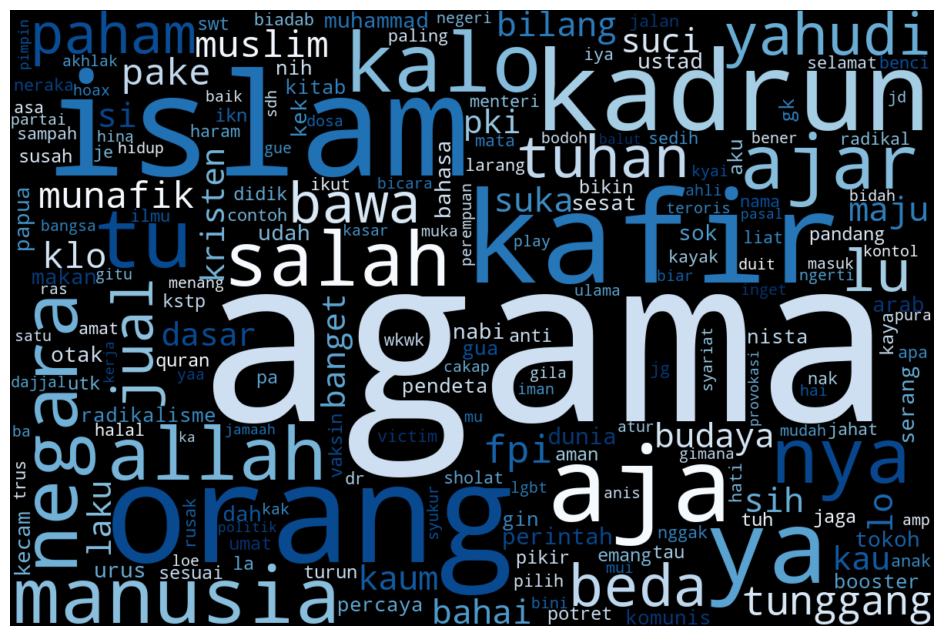

In [ ]:
# menampilkan data
def showing(wc):
    plt.figure(figsize=(12,8)) # ukuran
    plt.axis("off") 
    plt.imshow(wc, interpolation="bilinear")
    plt.show

# semua kata
allword = "".join([str(text).replace("'", "") for text in labeled_data.comment[labeled_data.label == "Agama"]])

# menyiapkan  komponen wordcloud
word_cloud = WordCloud(
    height=800,
    width=1200,
    collocations=False,
    colormap="Blues_r"
 ).generate(allword)

showing(word_cloud)

kata paling sering untuk class untuk class netral

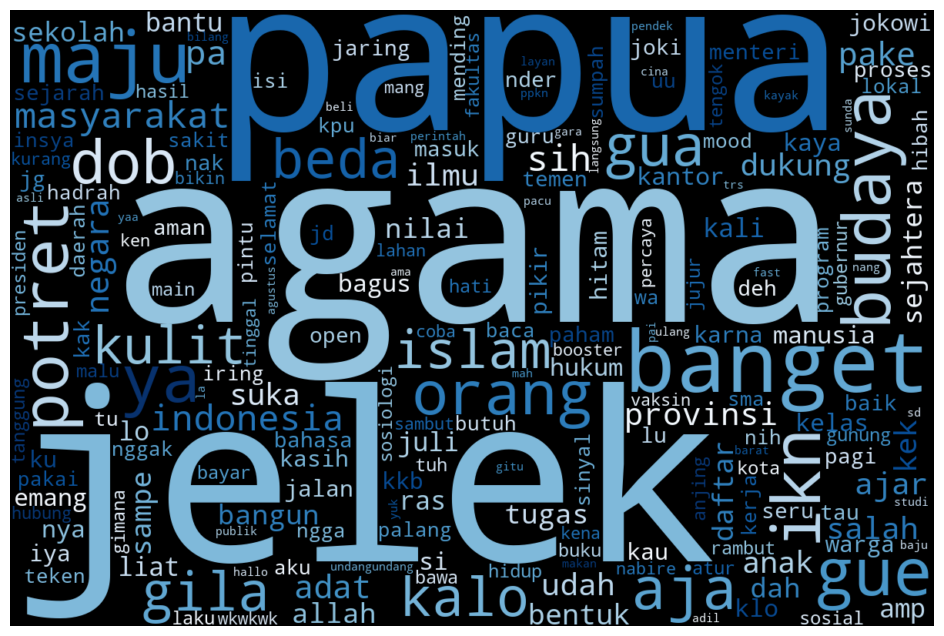

In [ ]:
# menampilkan data
def showing(wc):
    plt.figure(figsize=(12,8)) # ukuran
    plt.axis("off") 
    plt.imshow(wc, interpolation="bilinear")
    plt.show

# semua kata
allword = "".join([str(text).replace("'", "") for text in labeled_data.comment[labeled_data.label == "Netral"]])

# menyiapkan  komponen wordcloud
word_cloud = WordCloud(
    height=800,
    width=1200,
    collocations=False,
    colormap="Blues_r"
 ).generate(allword)

showing(word_cloud)

# **Pembobotan Kata**

### **Kalkulasi TF-IDF**

Pada tahapan ini kita akan melakukan perhitungan dalam **TFIDF** untuk nilai dari pembobotan kata berikut untuk tahapan tahapannya:
- Untuk tahapan awal kita akan melakukan perhitungan *term frequency* yaitu perhitungan **banyaknya term / kata yang muncul** untuk suatu dokumen **dibanding** dengan **banyak kata** yang ada di dokumen tersebut. untuk rumus dari TF atau *term frequency* adalah **TF** = kata *t* diulang di document *d* / banyak kata di document *d* 
- Untuk tahapan selanjutnya adalah kita akan menghitung dari *inverse document frequency* yaitu perhitungan berapa **banyak dokumen** yang didalamnya terdapat **kata *t***. Untuk rumusnya dari IDF atau *inverse document frequency* adalah **IDF** = log10(banyak document / banyak document yang di dalamnya ada kata *t* )
- Lalu pada tahapan selanjutnya adalah kita akan melakukan perhitungan untuk ***pembobotan suatu kata*** dengan *TF-IDF*  yaitu gabungan *term frequency* dan *inverse document frequency*. Cara menggabungkannya adalah dengan mengkali nilai dari TF dan IDF nya. rumus dari *TF IDF* adalah **TFIDF** = TF * IDF
- Lalu kita akan menentukan *TF IDF* untuk setiap item
- Lalu untuk mempermudah hasil analisa akan dilakukan normalisasi untuk nilai tf idf

In [130]:
X_train

1796    [indonesia, negara, hukum, assalamualaikum, le...
908     [gantung, interpretasi, masingmasing, individu...
575     [bukti, hrus, percaya, salah, percaya, salah, ...
1697    [turut, sakit, pakai, asesories, akar, budaya,...
1475    [balut, agama, makan, duit, donasi, luarbiasa,...
                              ...                        
906     [murtad, aja, les, susah, banget, allah, agama...
1510    [wartawan, rasmi, laman, reformasi, tik, tok, ...
1175    [urus, hmi, bandung, pakai, kalung, salib, lan...
1557    ['diemin', 'aja', 'akun', 'buzzer', 'seandaiya...
1558    [[], [], [], [], [], [], [], [], [], [], [], [...
Name: comment, Length: 1559, dtype: object

In [132]:
word_set = []

for doc in X_train:
    for word in doc:
        if word not in word_set:
            word_set.append(word)

n_document = len(X_train)


index_dict = {}
for i, term in enumerate(word_set):
    index_dict[term] = i
index_dict

{'indonesia': 0,
 'negara': 1,
 'hukum': 2,
 'assalamualaikum': 3,
 'lestari': 4,
 'waris': 5,
 'budaya': 6,
 'benda': 7,
 'pantun': 8,
 'gantung': 9,
 'interpretasi': 10,
 'masingmasing': 11,
 'individu': 12,
 'kemari': 13,
 'rumah': 14,
 'agama': 15,
 'kultus': 16,
 'raya': 17,
 'selesai': 18,
 'ber': 19,
 'bukti': 20,
 'hrus': 21,
 'percaya': 22,
 'salah': 23,
 'quran': 24,
 'turut': 25,
 'sakit': 26,
 'pakai': 27,
 'asesories': 28,
 'akar': 29,
 'kering': 30,
 'pikir': 31,
 'keliru': 32,
 'balut': 33,
 'makan': 34,
 'duit': 35,
 'donasi': 36,
 'luarbiasa': 37,
 'banget': 38,
 'rusak': 39,
 'lisan': 40,
 'manusia': 41,
 'tiga': 42,
 'badan': 43,
 'akh': 44,
 'kalo': 45,
 'analogi': 46,
 'nya': 47,
 'make': 48,
 'sepatu': 49,
 'dalem': 50,
 'gamau': 51,
 'lepas': 52,
 'kare': 53,
 'pake': 54,
 'baju': 55,
 'bodo': 56,
 'sulawesi': 57,
 'selatan': 58,
 'nder': 59,
 'kebaya': 60,
 'hijab': 61,
 'dayak': 62,
 'unik': 63,
 'dipakein': 64,
 'set': 65,
 'kerja': 66,
 'arab': 67,
 'udah': 6

In [136]:

# mencari document frequemcy
document_fre = {}
for term in X_train:
    document_fre[term] = 0
    for doc in X_train:
        if term in doc:
            document_fre[term] += 1

document_fre

TypeError: unhashable type: 'list'

In [133]:
def tf(word, doc):
    n = len(doc)
    occurate = doc.count(word)

    return occurate/n

In [ ]:
def idf(word):
    try:
        occurate = w

In [19]:
# melakukan implementasi untuk setiap data
dict = X_train.to_dict()
vectorizer = TFIDFVectorizer()
Vectorized_X_train = pd.DataFrame(vectorizer.Train(dict))
Vectorized_X_train = Vectorized_X_train.transpose()
Vectorized_X_train

,indonesia,negara,hukum,assalamualaikum,lestari,waris,budaya,benda,pantun,identitassehingga,...,contoh,rakyat,muncul,lsg,suntik,rambut,nasi,sabtu,carl,interpretasi
1796,0.098958,0.050159,0.067378,0.1,0.075624,0.08114,0.041263,0.075624,0.09057,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
908,0.000000,0.000000,0.000000,0.0,0.000000,0.00000,0.000000,0.000000,0.00000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.090909
575,0.000000,0.000000,0.000000,0.0,0.000000,0.00000,0.000000,0.000000,0.00000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
1697,0.000000,0.000000,0.000000,0.0,0.000000,0.00000,0.045848,0.000000,0.00000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
1475,0.000000,0.000000,0.000000,0.0,0.000000,0.00000,0.000000,0.000000,0.00000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1179,0.000000,0.000000,0.000000,0.0,0.000000,0.00000,0.000000,0.000000,0.00000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
1343,0.000000,0.000000,0.000000,0.0,0.000000,0.00000,0.000000,0.000000,0.00000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
906,0.000000,0.000000,0.000000,0.0,0.000000,0.00000,0.000000,0.000000,0.00000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
1510,0.000000,0.000000,0.000000,0.0,0.000000,0.00000,0.000000,0.000000,0.00000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000


### **Feature Selection**

Pada tahapan ini kita akan melakukan penyeleksian pada fitur lagi. **Mengapa kita perlu melakukan penyeleksian lagi ?** dikarenakan setelah melakukan perhitungan tf idf, masih ada yang harus diseleksi untuk membuat **performa model** menjadi **lebih baik** lagi. **term yang baik** adalah term yang **nilai tf idf** nya **tidak mendekati nol**, dikarenakan jika nilai tf idf yang mendekati nol, maka term itu sangat sekali jarang muncul dalam suatu dokumen. **Jika semakin jarang muncul** maka banyak item yang nilai tf idf nya nol sehingga data untuk term tersebut **tidak akan memiliki pola**. Oleh karena itu, kita dapat menghapus term tersebut. 

Tetapi sebelum melakukan itu, kita perlu untuk melakukan analisa untuk menemukan *threshold* (nilai tf idf minimal)

In [20]:
# semua term / feature
terms = Vectorized_X_train.columns

# mencari document frequemcy
document_fre = {}
for term in terms:
    document_fre[term] = 0
    for doc in X_train:
        if term in doc:
            document_fre[term] += 1

document_fre

{'indonesia': 41,
 'negara': 39,
 'hukum': 11,
 'assalamualaikum': 1,
 'lestari': 6,
 'waris': 4,
 'budaya': 75,
 'benda': 6,
 'pantun': 2,
 'identitassehingga': 1,
 'oh': 3,
 'merinding': 1,
 'lekas': 1,
 'ejcjsjcsjcjsx': 1,
 'temen': 10,
 'salam': 5,
 'order': 1,
 'kasanah': 1,
 'ngebayangin': 1,
 'anwar': 1,
 'musyawarah': 1,
 'ckckck': 2,
 'nenek': 1,
 'wikrama': 1,
 'jamaah': 3,
 'resume': 4,
 'benarbenar': 1,
 'akgae': 1,
 'kel': 1,
 'simpan': 2,
 'yakult': 1,
 'timer': 1,
 'oily': 1,
 'istimewa': 1,
 'hektar': 2,
 'sempurna': 3,
 'manusiamaupun': 1,
 'ajan': 1,
 'nekat': 1,
 'tgk': 4,
 'abisss': 1,
 'veronica': 1,
 'terorisme': 1,
 'kenal': 1,
 'rb': 1,
 'kog': 1,
 'kerah': 2,
 'mokasih': 1,
 'cerdas': 3,
 'ruin': 1,
 'immune': 1,
 'propokatif': 1,
 'man': 2,
 'bizi': 1,
 'ambil': 4,
 'warungmlyt': 1,
 'belenggu': 1,
 'bungkus': 2,
 'sudirman': 1,
 'wkwkwkwkwkw': 1,
 'exfo': 1,
 'katolik': 4,
 'irjen': 3,
 'santri': 1,
 'belajaq': 1,
 'fakultas': 6,
 'lagta': 1,
 'maher': 1,
 'a

Saya memutuskan untuk menentukan **threshold** berdasarkan **rata rata nilai tf idf** pada kata yang cukup **sering muncul**

In [21]:
# menentukan threshold
threshold = np.mean([Vectorized_X_train[c].mean() for c in Vectorized_X_train.columns if document_fre[c] > 4] )

threshold

0.0006213583278971017

Lalu setelah itu, saya akan mencari **term** yang **tidak memenuhi threshold** nya agar nantinya **dihapus**

In [22]:
# term yang tidak memenuhi
nonsense_word = [word for word in Vectorized_X_train.columns if Vectorized_X_train[word].mean() < threshold] 

nonsense_word

['hukum',
 'assalamualaikum',
 'lestari',
 'waris',
 'benda',
 'pantun',
 'identitassehingga',
 'oh',
 'merinding',
 'lekas',
 'ejcjsjcsjcjsx',
 'temen',
 'salam',
 'order',
 'kasanah',
 'ngebayangin',
 'anwar',
 'musyawarah',
 'ckckck',
 'nenek',
 'wikrama',
 'jamaah',
 'resume',
 'benarbenar',
 'akgae',
 'kel',
 'simpan',
 'yakult',
 'timer',
 'oily',
 'istimewa',
 'hektar',
 'sempurna',
 'manusiamaupun',
 'ajan',
 'nekat',
 'tgk',
 'abisss',
 'veronica',
 'terorisme',
 'kenal',
 'rb',
 'kog',
 'kerah',
 'mokasih',
 'cerdas',
 'ruin',
 'immune',
 'propokatif',
 'man',
 'bizi',
 'ambil',
 'warungmlyt',
 'belenggu',
 'bungkus',
 'sudirman',
 'wkwkwkwkwkw',
 'exfo',
 'katolik',
 'irjen',
 'santri',
 'belajaq',
 'fakultas',
 'lagta',
 'maher',
 'aktiviti',
 'okihita',
 'begoin',
 'langit',
 'offline',
 'deket',
 'gus',
 'akibat',
 'taumungkin',
 'pacar',
 'moment',
 'ijo',
 'na',
 'mebteri',
 'saksi',
 'eren',
 'kafirrrr',
 'ribet',
 'two',
 'jujur',
 'asong',
 'jiakh',
 'mata',
 'lumpuh

Setelah itu, kita dapat **menghilangkan** saja untuk term yang tidak memenuhi threshold tadi

In [23]:
# menghilangkan term / fitur yang tidak memenuhi
Vectorized_X_train.drop(columns=nonsense_word, inplace=True)

Vectorized_X_train

,indonesia,negara,budaya,tau,simak,bilang,sekolah,komunis,orang,kaya,...,munafik,keplak,menteri,jual,pas,jawa,tuh,jahat,mah,rambut
1796,0.098958,0.050159,0.041263,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
908,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
575,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
1697,0.000000,0.000000,0.045848,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
1475,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1179,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
1343,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.217017,0.0,0.187363,0.0,0.0,0.0,0.0,0.0
906,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
1510,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0


# **Klasifikasi**

### **Create Class**

Pada tahapan ini kita akan membuat sebuah class yang berisi algoritma dari knn beserta dengan perhitungan dari akurasi, recall, dan lain lain. Berikut merupakan penjelasan tentang class ini:
- **Constructor**, ini digunakan untuk menginisialisasi variable variable yang dibutuhkan dalam suatu class. Untuk isinya adalah *n_neighbors* ini digunakan untuk menentukan berapa tetangga terdekat untuk bisa melakukan voting. *Weight* atau bobot yaitu yang menentukan seberapa berat tingkat kedekatan antara data baru dengan data train yang akan menentukan voting. *x dan y* yaitu data train yang akan diperhitungkan jaraknya antara data baru dengan data lama. *accuracy* yaitu akurasi model. *precision* ini gunanya untuk menghitung seberapa tepat model kita itu menebak suatu class. *recall* adalah menghitung seberapa banyak model kita yang tepat pada prediksi suatu class

In [121]:
# algoritma knn
class KNN:
    # agar bisa dilakukan tunning parameter
    def __init__(self, n_neighbors=3, weight="uniform"):
        self.n_neighbors = n_neighbors # banyak k
        self.weight = weight # bobot
        self.x = None # x
        self.y = None # y
        self.accuracy = None # akurasi
        self.cm = None # confusion matrix
        self.precision = [] # semua class precision
        self.recall = [] # semua class recall
        self.f1score = [] # semua class f1 score

    # untuk training
    def fit(self, x, y):
        # jika banyak data x dan y tidak sama, akan terjadi error
        if len(x) != len(y):
            raise f"length of x is different with length of y, x = ({len(x)}) and y = ({len(y)})"
    
        # menyimpan variable x dan y nya
        # print(x)
        self.x = np.array(x)
        self.y = np.array(y)

    # membuat prediksi 
    def predict(self, x):
        # menghitung jarak
        distance = [np.sqrt(np.sum((x-x1)**2)) for x1 in self.x]

        # mencari jarak yang terdekat
        nearest = np.argsort(distance)[:self.n_neighbors]
        
        # menentukan label untuk jarak yang terdekat
        # print(nearest)
        labels = [self.y[i] for i in nearest]
        # print(x)
        # print(labels)

        # jika tidak menggunakan bobot
        if self.weight == "uniform":
            # print(np.bincount(labels).argmax())
            return np.bincount(labels).argmax()

        # jika menggunakan bobot
        if self.weight == "distance":
            # menghitung bobot
            weight =  [(1/(distance[i]+1e-10)) for i in  nearest]
            return np.bincount(labels, weight).argmax()
        
        # jika set parameter salah akan terjadi error
        raise "cannot use parameter, but 'uniform' or 'distance'"
    
    # menghitung akurasi dari model
    def accuracy(self, y_pred, y_true):

        n = len(y_pred) # banyak data
        counter = 0 # banyak jumlah benar

        # menghitung data yang benar
        for i in range(n):
            if y_pred[i] == y_true[i]:
                counter += 1

        return counter / n
    
    

    def deploy_predict(self, text):
        n_input = len(text)

        text = [case_folding(doc) for doc in text]
        # print(text)
        text = [tokenize(str(doc)) for doc in text]
        text = [normalize(doc) for doc in text]
        text = [stopword(doc) for doc in text]
        text = [stemming(doc) for doc in text]
        print(text)

        new_sentences = X_train
        new_sentences.loc[len(new_sentences.index)] = str(text)

        vectorizer = TFIDFVectorizer()
        Vectorized_X = pd.DataFrame(vectorizer.Train(new_sentences.to_dict()))
        Vectorized_X = Vectorized_X.transpose()

        deleted = []
        for col in Vectorized_X:
            if col not in Vectorized_X_train.columns:
                deleted.append(col)

        # print(deleted)
        Vectorized_X.drop(columns=deleted, inplace=True)
        # print(Vectorized_X)

        train = Vectorized_X.iloc[:-(n_input)]
        test = [Vectorized_X.iloc[-(n_input):]]

        predicteed = []
        self.x = train.to_numpy()
        for x in test:
            print("test")
            # print(self.predict(np.array(x)))
            predicteed.append(self.predict(np.array(x)))
        
        return predicteed

### **Training**

In [122]:
len(Vectorized_X_train.to_numpy()), len(y_train)

(1557, 1557)

In [123]:
Vectorized_X_train

,indonesia,negara,budaya,tau,simak,bilang,sekolah,komunis,orang,kaya,...,munafik,keplak,menteri,jual,pas,jawa,tuh,jahat,mah,rambut
1796,0.098958,0.050159,0.041263,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
908,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
575,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
1697,0.000000,0.000000,0.045848,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
1475,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1179,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
1343,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.217017,0.0,0.187363,0.0,0.0,0.0,0.0,0.0
906,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
1510,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0


In [124]:
# inisialisasi dengan tunning parameter
model = KNN(n_neighbors=3)


# training
model.fit(Vectorized_X_train.to_numpy(), y_train)
len(Vectorized_X_train)

1557

### **Testing**

In [125]:
Vectorized_X_train

,indonesia,negara,budaya,tau,simak,bilang,sekolah,komunis,orang,kaya,...,munafik,keplak,menteri,jual,pas,jawa,tuh,jahat,mah,rambut
1796,0.098958,0.050159,0.041263,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
908,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
575,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
1697,0.000000,0.000000,0.045848,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
1475,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1179,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
1343,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.217017,0.0,0.187363,0.0,0.0,0.0,0.0,0.0
906,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
1510,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0


In [126]:
X_test.iloc[0]

'@4D3II @Rhownyy @irgelexix diemin aja akun buzzer, seandaiya pulau kalimantan, papua,sulawesi dijual juga dia pastiâ€¦ https://t.co/7xUqRQjuxM'

In [127]:
predicts = model.deploy_predict([X_test.iloc[0]])
# for text in X_test:

predicts

[['diemin', 'aja', 'akun', 'buzzer', 'seandaiya', 'pulau', 'kalimantan', 'papuasulawesi', 'jual']]


test


IndexError: index 1557 is out of bounds for axis 0 with size 1557

In [ ]:
y_test

1662       Ras
1454    Netral
1022    Netral
1103    Netral
310     Netral
         ...  
1616       Ras
664        Ras
432        Ras
1014       Ras
895     Netral
Name: label, Length: 389, dtype: object

In [ ]:
model.deploy_predict(X_test.iloc[:30])

[['diemin', 'aja', 'akun', 'buzzer', 'seandaiya', 'pulau', 'kalimantan', 'papuasulawesi', 'jual'], ['gue', 'citacita', 'mimpi', 'bebas', 'suami', 'gue', 'bebas', 'ya', 'gue', 'hak', 'bebas', 'gue'], ['sore', 'open', 'joki', 'tugas', 'bahasa', 'sunda', 'ppkn', 'kewarganegaraan', 'agama', 'islam', 'pai', 'fast', 'wa'], ['komplek', 'gua', 'cant', 'relate'], ['sumpa', 'nyesel', 'liat', 'muka', 'gua', 'karna', 'jujur', 'gua', 'jelek'], ['humor', 'jelek', 'banget'], ['ngomongnya', 'pacar', 'larang', 'agama', 'tuh', 'pp', 'aurat', 'ditonjolin'], ['pooh', 'jelek', 'sekaliii', 'babi', 'hutan', 'ansel', 'gemas', 'main', 'bulubulu', 'pipi', 'pooh', 'ayo', 'makan', 'jelek', 'bi'], ['krisantus', 'ajak', 'warga', 'dayak', 'lestari', 'budaya', 'tingkat', 'kualitas', 'sdm'], ['contoh', 'tulis', 'sesuai', 'yaa'], ['udah', 'jelek', 'brengsek'], ['sayang', 'padang', 'ras', 'warna', 'kulit'], ['pakai', 'adat', 'jawa', 'bahasa', 'arab', 'munafik', 'mbok', 'tanggung', 'mus'], ['ahokphobia', 'kadrun', 'bangs

test


[0]

### **Tunning Result**

# **Solusi**

### Inisialisasi Library

In [ ]:
import tkinter

### Inisialisasi Konstruksi UI

In [ ]:
class UI:
    def __init__(self) -> None:
        self.Header = ("Century Gothic", 28)
        self.Subheader1 = ("Segoe UI", 28)
        self.Subheader2 = ("Segoe UI", 24)
        self.Subheader3 = ("Segoe UI", 20)
        self.Subheader4 = ("Segoe UI", 12)
        self.button_font = ("Segoe UI", 13)
        self.Decoration = ("Wingdings", 24)

        self.background_color = "#0F3E6E"
        self.foreground_color = "#ffffff"
        self.textbox_color = "#092745"
        self.accent_color = "#ffffff"
        

        self.root = tkinter.Tk()
        self.root.geometry("600x850")
        self.root.title("Klasifikasi Teks Menggunakan TF-IDF")
        self.root.configure(background=self.background_color)
        self.root.resizable("False", "False")
        self.home()
        self.root.mainloop()

    def home(self):
        tkinter.Label(master=self.root, text="Penerapan Algoritma KNN", font=self.Subheader1, background=self.background_color, foreground=self.foreground_color).pack(pady=(30, 0))
        tkinter.Label(master=self.root, text="Dengan Metode TF-IDF", font=self.Subheader2, background=self.background_color, foreground=self.foreground_color).pack()
        tkinter.Label(master=self.root, text="Untuk Klasifikasi Komentar Rasisme", font=self.Subheader3, background=self.background_color, foreground=self.foreground_color).pack()
        
        tkinter.Label(master=self.root, text="Inputkan Teks Anda Di Bawah:", font=self.Subheader4, background=self.textbox_color, foreground=self.foreground_color, padx=76).pack(pady=(20, 0))
        textbox = tkinter.Text(self.root, width=40, height=20, relief="flat", font=self.Subheader4, background=self.textbox_color, foreground=self.foreground_color)
        textbox.pack()
        

        tkinter.Button(master=self.root, text="Predict", font=self.button_font, command=lambda: self.predict(textbox.get("1.0", "end")), relief="flat", width=20, foreground=self.foreground_color, background=self.textbox_color, highlightbackground=self.background_color, highlightcolor=self.background_color, activebackground=self.background_color).pack(pady=10)
        self.ClassifyResultTextBox = tkinter.Text(self.root, width=40, height=1, relief="flat", font=self.Subheader4, background=self.textbox_color,foreground=self.foreground_color)
        self.ClassifyResultTextBox.insert("1.0", "Prediksi Class : ")
        self.ClassifyResultTextBox.configure(state="disabled")
        self.ClassifyResultTextBox.pack()

        #tkinter.Label(master=self.root, text="4", font=self.Decoration, foreground=self.foreground_color, background=self.background_color).pack(pady=35)
    
    def predict(self, text=""):
        self.ClassifyResultTextBox.configure(state="normal")
        self.ClassifyResultTextBox.delete("0.0", "end")
        self.ClassifyResultTextBox.insert("1.0", "Prediksi Class : "+text)
        self.ClassifyResultTextBox.configure(state="disabled")

In [ ]:
tkinter_ui = UI()